# Defining and Training a Neural Network

* Micrograd is an Autograd (Automatic Gradient) Engine
    - Implements backpropagation
* What is a gradient?
    - Represents the rate of change of the loss function with respect to the
      model's parameters --> find best parameters to yield best prediction
* What is backpropagation?
    - Algorithm that allows you to efficiently evaluate the gradient of the
      loss function with respect to the weights of the neural network
          -  can iteratively tune the weights to minimize the loss function
    - Mathematical core of any modern deep neural network library
* Neural Networks: a certain class of mathematical expressions
    - Take input data and weights of the neural network as inputs
    - Output is predictions of the neural network or loss function
    - Backpropagation is a more general and is employed for training neural networks
        -  Doesn't care about neural networks (only cares about arbitrary mathematical expressions)
    - Neural networks are massive expressions so we need data structure to maintain these expressions (micrograd)
* Tensor: an algebraic object that describes a multilinear relationship between sets of algebraic objects related to a vector space

In [54]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._backward = lambda : None
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2)  * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [24]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

In [11]:
# Node visualizer
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot




**Calculating the gradients of the nodes with respect to F (Backpropagation)**
- Backpropagation: recursive application of the chain rule backwards through the computation graph


**Creating a Neuron**

In [14]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# activation function (tanh)
o = n.tanh(); o.label = 'o'
o.backward()

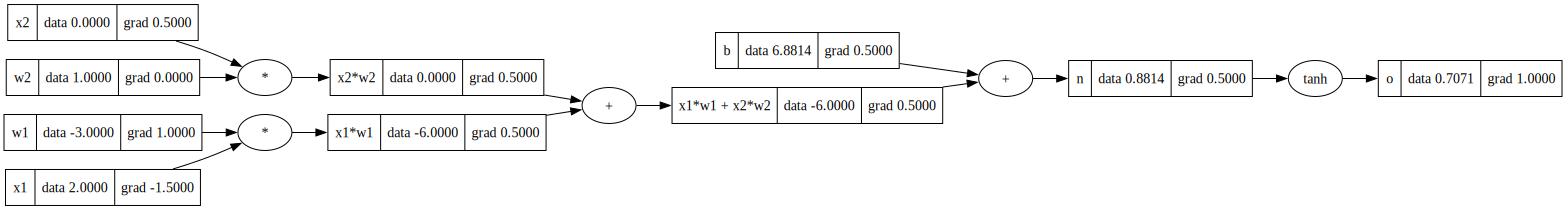

In [15]:
draw_dot(o)

**Back propagation of the neuron (Automated)**
- In back propagation, the gradients are calculated in topological order
    - We need to get the dependencies of the a particular node taken care of before calling ._backward() on a particular node as shown below (o to x1/x2)
    - This ordering of the graphs can be achieved through topological sort

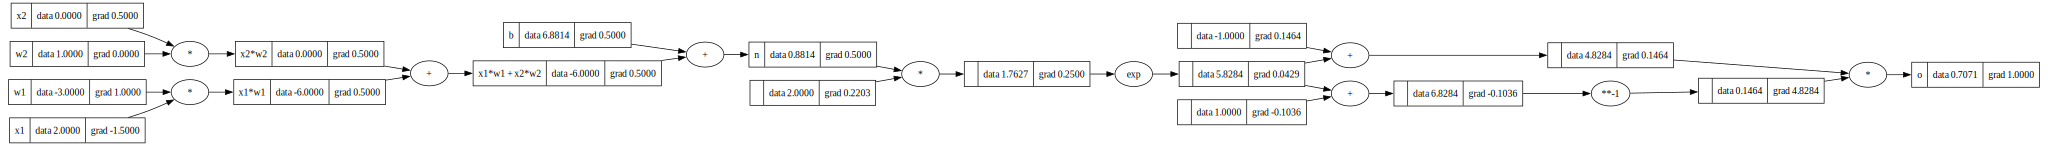

In [55]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# activation function (tanh)
e = (2 * n).exp()
o = (e - 1) / (e + 1); o.label = 'o'
o.backward()
draw_dot(o)

In [57]:
import torch

In [62]:
x1 = torch.Tensor([2.0]).double()                   ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                   ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                  ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                   ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()     ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-----')
print(x2.grad.item())
print(w2.grad.item())
print(x1.grad.item())
print(w1.grad.item())


0.7071066904050358
-----
0.5000001283844369
0.0
-1.5000003851533106
1.0000002567688737


In [199]:
import random

class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

# Multi-Layer Perceptron: An input later, one or more hidden layers, and an output layer
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.14144726980264713)

In [200]:
n.parameters()

[Value(data=0.7664441649004634),
 Value(data=0.15741714712565336),
 Value(data=-0.5418577166772942),
 Value(data=0.04485600615041596),
 Value(data=-0.6055115820678443),
 Value(data=0.20621277547686456),
 Value(data=-0.2063152987084227),
 Value(data=0.3468213406179237),
 Value(data=-0.7606808739207709),
 Value(data=-0.8139114606446984),
 Value(data=0.9946157479131081),
 Value(data=-0.7779743490242714),
 Value(data=0.5396674221926727),
 Value(data=0.5087544056457389),
 Value(data=-0.0023137245994444555),
 Value(data=0.9494247152767945),
 Value(data=-0.8996609479756577),
 Value(data=0.13597532905684484),
 Value(data=-0.5879049105489473),
 Value(data=0.06835278744358808),
 Value(data=0.9282875240953818),
 Value(data=0.8720250089836541),
 Value(data=0.7671039497064911),
 Value(data=0.19384747489869114),
 Value(data=-0.502676147741878),
 Value(data=-0.34284468737153095),
 Value(data=-0.5811404414871619),
 Value(data=-0.36855466349864074),
 Value(data=0.5884003518049068),
 Value(data=0.495434

In [201]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.14144726980264713),
 Value(data=-0.3671617231928157),
 Value(data=-0.4814807025034095),
 Value(data=-0.09781745874697587)]

In [252]:
for k in range(100):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # reset/flush grad
    for p in n.parameters():
        p.grad = 0.0

    # backward pass
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 0.000259746947626716
1 0.00025961110385471723
2 0.000259475398115409
3 0.00025933983020084495
4 0.0002592043999034867
5 0.0002590691070162189
6 0.00025893395133232095
7 0.0002587989326455119
8 0.000258664050749891
9 0.0002585293054399974
10 0.0002583946965107567
11 0.00025826022375751226
12 0.0002581258869760074
13 0.0002579916859624047
14 0.0002578576205132638
15 0.00025772369042553745
16 0.0002575898954966015
17 0.00025745623552421356
18 0.00025732271030655634
19 0.0002571893196421832
20 0.0002570560633300723
21 0.0002569229411695842
22 0.00025678995296048184
23 0.00025665709850292135
24 0.0002565243775974593
25 0.00025639179004504633
26 0.00025625933564700954
27 0.0002561270142050965
28 0.00025599482552141496
29 0.0002558627693984957
30 0.0002557308456392299
31 0.00025559905404690716
32 0.00025546739442521894
33 0.00025533586657821135
34 0.0002552044703103527
35 0.0002550732054264585
36 0.0002549420717317636
37 0.0002548110690318608
38 0.00025468019713273664
39 0.00025454945584074

In [253]:
ypred

[Value(data=0.9932297165853576),
 Value(data=-0.9896077459240216),
 Value(data=-0.9949946641513593),
 Value(data=0.9917508899476377)]